In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress

In [2]:
#paramaters
#change all units to: force = pN, length = nm, time = ms
pars = {}
pars['a00'] = -21*10**-3
pars['a01'] = 0
pars['a10'] = 0
pars['a11'] = -1
pars['gamma0'] = 8.72
pars['gamma1'] = 54.8

pars['kbT'] = 4.1
pars['noise0'] = 2*pars['gamma0']*pars['kbT']
pars['noise1'] = 4.916*(1e3)

pars['delta_t'] = 0.01

In [3]:
def euler_one_traj(n_time, pars):   
    #initial condition
    x1 = 0
    x2 = 0
    x1_traj = []
    x2_traj = []
    
    #performing 1 traj with n_time number of data points
    for i in range(n_time):
        #generate delta_B
        s1 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        s2 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        #solve for x1, x2
        x1_new = x1 + (pars['a00']/pars['gamma0'])*x1*pars['delta_t'] + \
        (pars['a01']/pars['gamma0'])*x2*pars['delta_t'] + \
        np.sqrt((pars['noise0'])/((pars['gamma0'])**2))*s1
                 
        x2_new = x2 + (pars['a11']/pars['gamma1'])*x2*pars['delta_t'] + \
        (pars['a10']/pars['gamma1'])*x1*pars['delta_t'] + \
        np.sqrt((pars['noise1'])/((pars['gamma1'])**2))*s2
                
        x1 = x1_new
        x2 = x2_new
        
        x1_traj.append(x1)
        x2_traj.append(x2)
    return x1_traj, x2_traj

In [4]:
def calc_stochastic_heat_q1(x1, x2, pars):
    """Calculates stochastic heat per time delta following equation (3)
    Input:
    x1 (list) = x1_trajectory_list
    x2 (list) = x2_trajectory_list
    pars (dictionary) = parameters
    
    Here's an example:
    x1 =       [1,2,3,4,5]
    x1_shift = [5,1,2,3,4]
    Then we can easily calculate operations, e.g. dx1 = x1 - x1_ shift
    Vectorization (technique of implementing array operations without using for loop) is easier.
    
    After which, we discard the first element
    
    Returns:
    stochastic heat as shown in equation (3)"""
    x1_shift = np.roll(x1, shift = 1)   
    x2_shift = np.roll(x2, shift = 1)
    
    first_term = -pars['a00']*((x1 + x1_shift)/2)
    second_term = -pars['a01']*((x2 + x2_shift)/2)
    dx1 = x1 - x1_shift
    return (first_term[1:] + second_term[1:])*dx1[1:]

def calc_stochastic_heat_q2(x1, x2, pars):
    x1_shift = np.roll(x1, shift = 1)   
    x2_shift = np.roll(x2, shift = 1)    
    
    first_term = -pars['a11']*((x2 + x2_shift)/2)
    second_term = -pars['a10']*((x1 + x1_shift)/2)
    dx2 = x2 - x2_shift
    return (second_term[1:] + first_term[1:])*dx2[1:]

In [5]:
#function to calculate average q (cumulative_heat) after performing n_realizations
def average_q(max1_time, pars):
    min_time = 0
    n_time = int((max1_time - min_time)/pars['delta_t'] + 1) #n_time = num of evenlx2 spaced samples (ex1. 1001 points)
    time = np.linspace(min_time, max1_time, n_time) #time(ex1. 0 (min time), 0.01, 0.02, ..., 10 (max1 time)) with n_time no. of data points
    
    average_q1_trajectorx2 = 0
    average_q2_trajectorx2 = 0
    
    relax_time = int(abs(pars['gamma0']/pars['a00']))
    
    for i in tqdm(range(pars['n_realizations'])):
        x1_traj, x2_traj = euler_one_traj(n_time, pars)
        final_x1_traj = x1_traj[relax_time::]
        final_x2_traj = x2_traj[relax_time::]
        
        
        q1_trajectorx2 = calc_stochastic_heat_q1(final_x1_traj, final_x2_traj, pars)
        q1_cumulative = np.cumsum(q1_trajectorx2)
        
        q2_trajectorx2 = calc_stochastic_heat_q2(final_x1_traj, final_x2_traj, pars)
        q2_cumulative = np.cumsum(q2_trajectorx2)
        
        average_q1_trajectorx2 += q1_cumulative/pars['n_realizations']
        average_q2_trajectorx2 += q2_cumulative/pars['n_realizations']
        
    return average_q1_trajectorx2, average_q2_trajectorx2, time[:-1]

In [6]:
%%time
pars['n_realizations'] = 100
q1_neq, q2_neq, time = average_q(500, pars)

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]

Wall time: 1min 29s


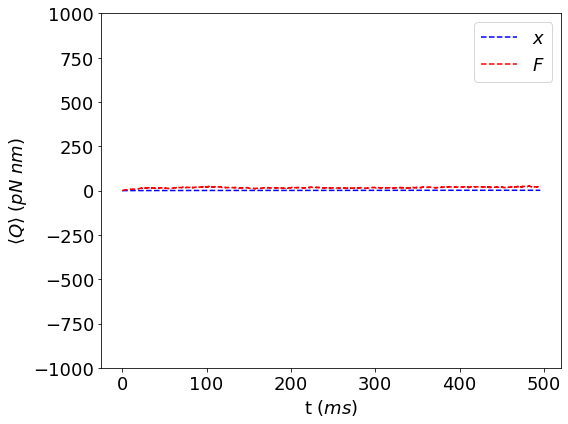

In [7]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
x_axis_plot = np.arange(0, len(q1_neq), 0.01)[:len(q1_neq)]
ax.plot(x_axis_plot, q1_neq, color = 'blue', linestyle='dashed', label = '$x$')
ax.plot(x_axis_plot, q2_neq, color = 'red',  linestyle='dashed', label= '$F$')
plt.xlabel('t ($ms$)', fontsize=18)
plt.ylabel('$\\left<Q \\right>$ ($pN$ $nm$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(prop={'size': 18})
plt.ylim(-1000, 1000)
plt.tight_layout()
plt.savefig('stoch_heat_lorentzian_fin.png', dpi=100)
plt.show()

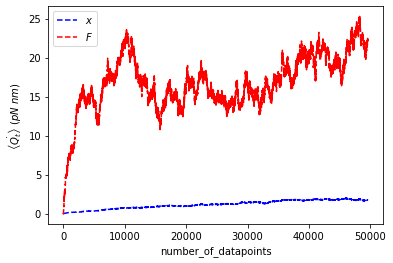

In [8]:
plt.plot(q1_neq, color = 'blue', linestyle='dashed', label = '$x$')
plt.plot(q2_neq, color = 'red',  linestyle='dashed', label= '$F$')
plt.xlabel('number_of_datapoints')
plt.ylabel('$\\left<\dot{Q_t} \\right>$ ($pN$ $nm$)')
plt.legend()
plt.show()

In [9]:
x_axis = np.linspace(0,len(q1_neq)*pars['delta_t'], len(q1_neq))
x_axis

array([0.00000000e+00, 1.00002017e-02, 2.00004034e-02, ...,
       4.95830000e+02, 4.95840000e+02, 4.95850000e+02])

In [10]:
result_neq_x1 = linregress(x_axis, q1_neq)
print('slope_neq_x1', result_neq_x1.slope)
result_neq_x2 = linregress(x_axis, q2_neq)
print('slope_neq_x2', result_neq_x2.slope)

print('slope_neq_x1 + slope_neq_x2', result_neq_x1.slope + result_neq_x2.slope)

slope_neq_x1 0.003579388161464635
slope_neq_x2 0.014439935451336336
slope_neq_x1 + slope_neq_x2 0.01801932361280097
